<img src="https://www.bestdesigns.co/uploads/inspiration_images/4350/990__1511457498_404_walmart.png" alt="WALMART LOGO" />

## Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

#### Import des librairies

In [3]:
!pip install plotly==5.0.0 -q
!pip install missingno -q
%matplotlib inline 
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import sklearn
from numpy import arange
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split,LeaveOneOut
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve,mean_squared_error ,r2_score,mean_absolute_error
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly.graph_objects as go, plotly.express as px, plotly.io as pio
import statsmodels.api as st
import matplotlib.pyplot as plt
import plotly.express as px

pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

In [5]:
dataset = pd.read_csv('Walmart_Store_sales.csv')

## Data cleaning

In [8]:
print("Total of columns and rows : {}".format(dataset.shape))

Total of columns and rows : (150, 8)


In [19]:
print("Basics statistics: ")
display(dataset.describe(include='all'))

Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,07-01-2011,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [18]:
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

we can notice in this first view, some to datas to rectify : 

there are some missing values, some times more than 10 % of the datas (for example, for the temperature or the dates), so some NaN to drop ; the dates has the wrong format...

In [20]:
#Here, we are going to drop the missing values of the columns "Weekly_sales"
WS_nan = dataset.index[dataset.iloc[:,2].isnull()]
dataset.drop(WS_nan,0, inplace=True)

In [21]:
# Rectify the dates in a right format :
dataset['semaine'] =pd.to_datetime(dataset['Date']).dt.isocalendar().week
dataset['année'] = pd.to_datetime(dataset['Date']).dt.isocalendar().year
dataset['mois'] = pd.to_datetime(dataset['Date']).dt.month
dataset['true_date'] = pd.to_datetime(dataset['Date'])
dataset['true_date'].sort_values()

14    2010-01-10
20    2010-02-04
47    2010-02-07
99    2010-02-07
112   2010-02-19
         ...    
92           NaT
102          NaT
129          NaT
137          NaT
146          NaT
Name: true_date, Length: 136, dtype: datetime64[ns]

In [22]:
# in order to get a better understanding, we are going to convert Farheineit in degre C°
dataset['Temperature'] = ((dataset['Temperature'])-32)/1.8

## EDA

In [28]:
# Influence of temperature on sales per store
fig = px.scatter(dataset, x='Store',y='Weekly_Sales', color='Temperature')
fig.show()

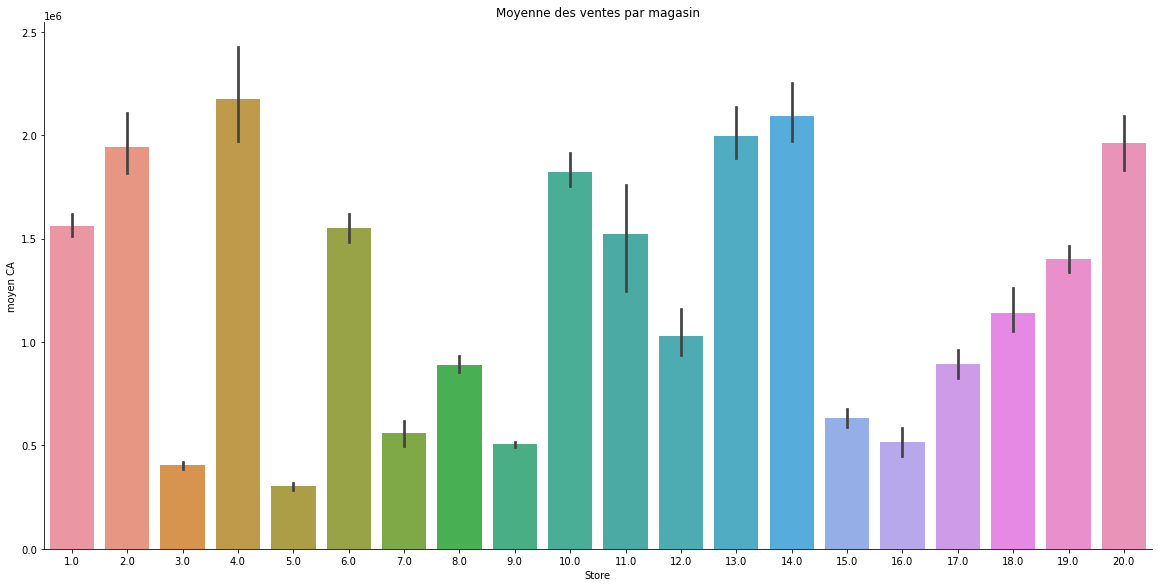

In [29]:
# Average sales per store
g1 = dataset.groupby("Weekly_Sales")['Store'].mean().reset_index()

ax = sns.catplot( x="Store",y='Weekly_Sales',data = g1, kind='bar',
                    height=8,
                    aspect=2)
ax.set(title='Moyenne des ventes par magasin', xlabel="Store", ylabel="moyen CA")
plt.show;

we can see on this graph a great disparity of sales per store

Text(0.5, 1.0, 'Average sales per months and per years')

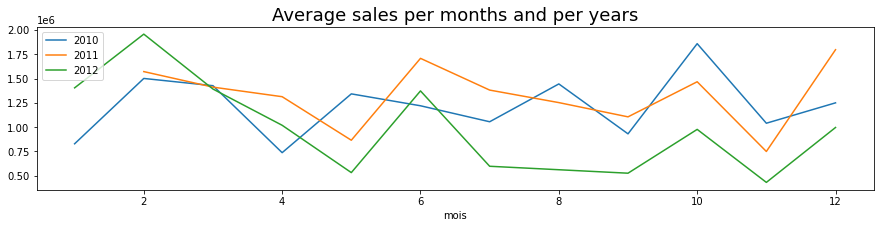

In [31]:
# Average sales per month and year
plt.figure(figsize=(15,3))
dataset[dataset['année']==2010].groupby('mois')['Weekly_Sales'].mean().plot()
dataset[dataset['année']==2011].groupby('mois')['Weekly_Sales'].mean().plot()
dataset[dataset['année']==2012].groupby('mois')['Weekly_Sales'].mean().plot()
plt.legend(['2010', '2011', '2012'], fontsize=10)
plt.title('Average sales per months and per years', fontsize=18)

This graphs show us the sales on the 3 last years, and we can see a commun pattern between the 3 curves as seasonality. But it seems there are some disparities.

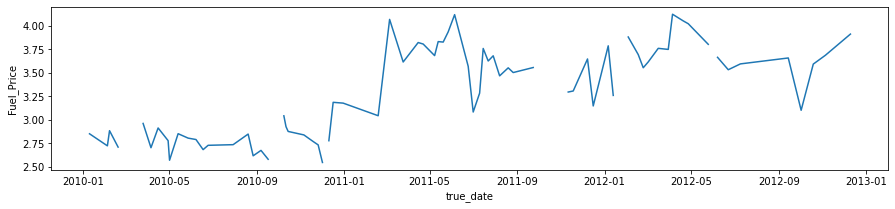

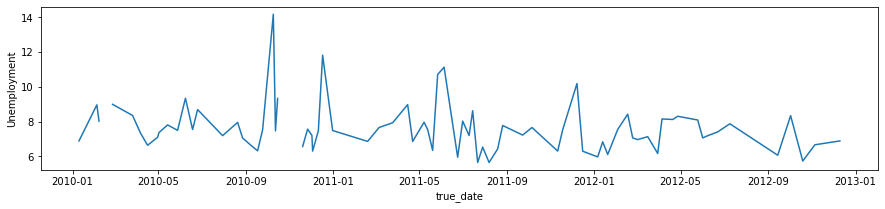

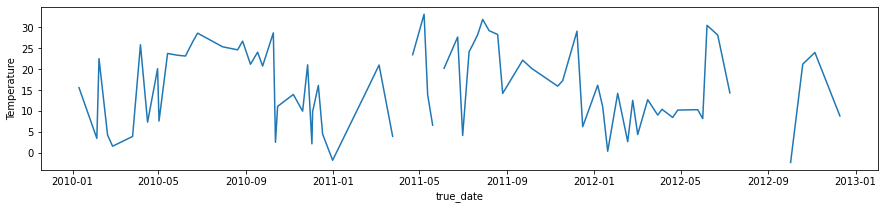

In [33]:
def plt_figure (variable):
    plt.figure(figsize=(15,3))
    dataset.groupby('true_date')[variable].mean().plot(subplots=True, figsize=(20,15));
    plt.ylabel(variable)
    
plt_figure('Fuel_Price')
#plt_figure('CPI')
plt_figure('Unemployment')
plt_figure('Temperature')
#These features can influence the rate of frequentation of the stores

These external indicators give us indications on the influence on sales. For example, we can see in the third graph that the temperature seems to have an influence on the sales, especially in case of low temperature. We can also see that the cost of fuel is constantly increasing and that unemployment is decreasing.

In [34]:
#suppression des valeurs aberrantes
print('Nombre de ligne ',dataset[:].shape [0])
liste_col = ('Temperature','Fuel_Price','CPI','Unemployment')
for element in liste_col:
    borne_inf = dataset[element].mean() - 3 *dataset[element].std() 
    borne_sup = dataset[element].mean() + 3 *dataset[element].std()
    mask = ((dataset[element] < borne_inf) | (dataset[element] > borne_sup))
    print(mask.sum())
    dataset2 = dataset.loc[~mask,:]
print('Nombre de ligne ',dataset2[:].shape [0])

Nombre de ligne  136
0
0
0
5
Nombre de ligne  131


We remove outliers that are outside the range : [𝑋¯−3𝜎,𝑋¯+3𝜎] . In machin learning, these values are considered as outliers. we delete them in order to avoid to distort the learning

## Linear regression

In [37]:
# Separation of the variables Y and X
features_list = ["Store","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment"]
target_variable = "Weekly_Sales"

X = dataset2.loc[:,features_list]
Y = dataset2.loc[:,target_variable]

# Divide dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=0)

# Convert the pandas Datafram in numpy (pandas not supported byscikit-learn)
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()


# Create pipeline for numerical features
numeric_features = [2,3,4,5]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values in Age will be replaced by columns' mean
    ('scaler', StandardScaler())])

# Create pipeline for categorical features
categorical_features = [0, 1]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first'))]) # first column will be dropped to avoid creating correlations between features

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set on utilise .todense 
# pour éviter de transformer notre variable en sparce matrix
X_train = preprocessor.fit_transform(X_train)
X_train = X_train.todense()
#Preprocessings on test set
X_test = preprocessor.transform(X_test)
X_test = X_test.todense()

# Encoding categorical features and standardizing numerical features

# Train model
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# Predictions on training set
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

# Calculate evaluation métricss
coef = regressor.coef_
rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100
SST = np.sum(np.square(Y_train- np.mean(Y_train)))
SSE = np.sum(np.square(regressor.predict(X_train) - np.mean(Y_train)))
SSR = np.sum(np.square(Y_train - regressor.predict(X_train)))
R_2 = 1 - SSR/SST
R_2_alt = regressor.score(X_train,Y_train) 
n = X.shape[0]
p = X.shape[1]
R_2_adj = 1 - (n-1)/(n-p-1)*(1-R_2)

# les métriques d'évaluation
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))
print("\n")
print('root mean square error :', rmse)
print('mean absolute percentage error :' ,mape)
print("\n")

R2 score on training set :  0.9629121558724477
R2 score on test set :  0.9390204016214599


root mean square error : 127100.96458261933
mean absolute percentage error : 7.579988263981298




We can notice that we have a very good score on the test and on the train set, which is 94%

## Ridge as regularized regression model

In [39]:
regressor = Ridge()
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

params = {
    'alpha': [0.001,0.01,0.04,0.05, 0.2, 0.3, 0.4,0.7]}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) #verbose = 2 pour voir l'entrainement pour chaques param

gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

# Predictions on training set
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)
print("\n")
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100

print("\n")
print('root mean square error :', rmse)
print('mean absolute percentage error :' ,mape)

The cross-validated R2-score is :  0.8251329664383147
The standard deviation is :  0.037962560529014804
Best hyperparameters :  {'alpha': 0.04}
Best R2 score :  0.9132959997559483


R2 score on training set :  0.9626996713621638
R2 score on test set :  0.9392220282780426


root mean square error : 127464.53942778295
mean absolute percentage error : 7.491524796620455


With the GridSearch, we can notice than R2 decrease a bit. Gridsearch is definitively a good tool in order to optimise our model and to avoid overfitting.

## Lasso

In [41]:
reg = LassoCV(cv=3, alphas=None)
reg.fit(X_train,Y_train)

Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)
#print('montant de la pénalisation choisi:',reg.alpha_)
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
mape = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100

print("\n")
print('root mean square error :', rmse)
print('mean absolute percentage error :' ,mape)

features = list(preprocessor.transformers_[1][1]['encoder'].get_feature_names())
num_var = ['Temperature','Fuel_Price','CPI','Unemployment']
Z = features + num_var
Z = pd.DataFrame(Z) 
coef = pd.DataFrame(reg.coef_,columns=['coef'])
coeff = pd.concat([Z,coef],axis=1)
coeff.groupby(['coef']).sort


df = pd.DataFrame({
            "Parameter":reg.coef_[reg.coef_!=1]})

coef_variable = pd.concat([Z,df],axis=1)
#print(coef_variable)

R2 score on training set :  0.961930080697494
R2 score on test set :  0.9413505709163408


root mean square error : 128772.76770853215
mean absolute percentage error : 7.5267770865028085


The regularisation with Lasso (l1) get a better performance than the ridge regularisation, with score test up to 94%

## Conclusion :

At the end, we are able to say that our models are fine to get a good sales prediction per week, and to analyse the 